# Taxi Demand Prediction

Sweet Lift Taxi company wants to predict the number of taxi orders for the next hour to optimize driver allocation during peak hours. We'll build a time series forecasting model with RMSE ≤ 48 on the test set.

## Data Description
- Dataset: `/datasets/taxi.csv`
- Columns:
    - `datetime`: Timestamp of the record
    - `num_orders`: Number of taxi orders

## Initialization

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import ar_select_order, AutoReg
from statsmodels.tsa.arima.model import ARIMA
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor

## Load data

In [2]:
# Load the data files into different DataFrames
try:
    df= pd.read_csv('taxi.csv', parse_dates=[0], index_col=[0])
except:
    df = pd.read_csv('datasets/taxi.csv', parse_dates=[0], index_col=[0])

df.head(3)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28


## EDA

We Have so many nulls in this data that we would need to deal with them when

In [4]:
# Extract relevant columns
df.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
num_orders,26496.0,14.070463,9.21133,0.0,8.0,13.0,19.0,119.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [6]:
# Counting the nulls
df.isna().sum()

num_orders    0
dtype: int64

Our data has no nulls, and we can't check the number of duplicates as it's totally normal if we get the same order in different time

In [7]:
# Check if the index sorted
df.index.is_monotonic_increasing

True

Our Data is sorted, so we can start resampling it

In [8]:
df= df.resample('1h').sum()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


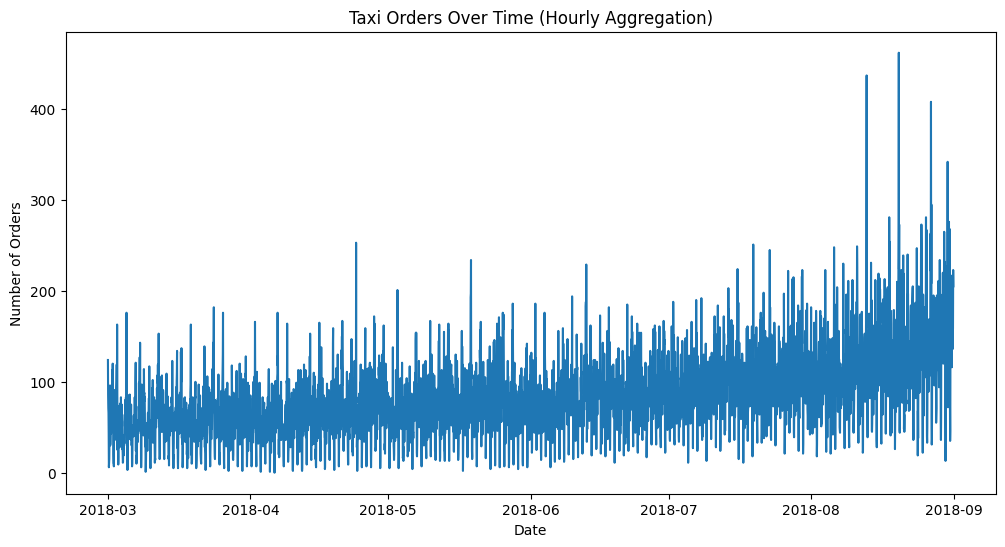

In [9]:
# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['num_orders'])
plt.title('Taxi Orders Over Time (Hourly Aggregation)')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.show()


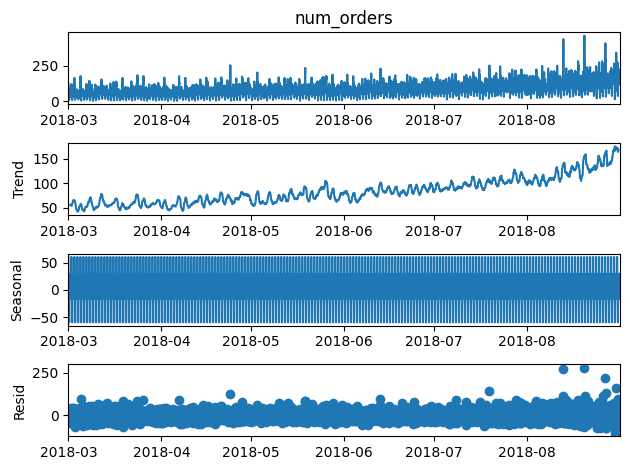

In [10]:
# Decompose the time series to observe trend and seasonality
decomp = seasonal_decompose(df['num_orders'], model='additive', period=24)
decomp.plot()
plt.tight_layout()
plt.show()

In [11]:
# run the adfuller test to check for stationarity
adfuller(df, autolag='AIC')[1]

0.028940051402612906

From the plot and the adfuller test (less than .05), we can say that our data is stationary and we can start working on it

<Figure size 1600x400 with 0 Axes>

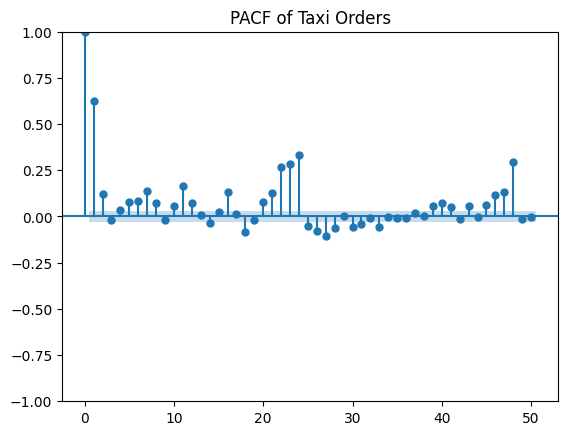

In [12]:
# Plot PACF to identify seasonality patterns
plt.figure(figsize=(16, 4))
plot_pacf(df['num_orders'], lags=50)
plt.title('PACF of Taxi Orders')
plt.show()

Because the data is hourly, this plot shows that the number of orders at a certain time is mostly affected by the number of orders at the same time on previous days.

From this grapgh, I found the best lags would be [1 , 2, 5, 6, 7, 11, 12, 21, 22, 23, 24, 26, 27, 46, 47, 48]

## Feature Engineering

In [13]:
def create_features(df):
    df= df.copy()

    df['hour']= df.index.hour
    df['day_of_week']= df.index.dayofweek
    df['day_of_month']= df.index.day
    df['month']= df.index.month

    # Lag features
    for lag in [1,2,5,6,7,11,12,21,22,23,24, 26,27,46,47,48]:
        df[f'lag_{lag}']= df['num_orders'].shift(lag)

    # Rolling window features
    df['rolling_mean_24']= df['num_orders'].shift().rolling(24).mean()
    df['rolling_std_24']= df['num_orders'].shift().rolling(24).std()

    return df

In [14]:
df_featured= create_features(df)
df_featured= df_featured.dropna()
df_featured.head()

,num_orders,hour,day_of_week,day_of_month,month,lag_1,lag_2,lag_5,lag_6,lag_7,...,lag_22,lag_23,lag_24,lag_26,lag_27,lag_46,lag_47,lag_48,rolling_mean_24,rolling_std_24
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-03 00:00:00,163,0,5,3,3,72.0,119.0,49.0,89.0,83.0,...,75.0,120.0,90.0,113.0,66.0,71.0,85.0,124.0,62.750000,32.715174
2018-03-03 01:00:00,108,1,5,3,3,163.0,72.0,93.0,49.0,89.0,...,64.0,75.0,120.0,58.0,113.0,66.0,71.0,85.0,65.791667,38.279270
2018-03-03 02:00:00,25,2,5,3,3,108.0,163.0,101.0,93.0,49.0,...,20.0,64.0,75.0,90.0,58.0,43.0,66.0,71.0,65.291667,37.612994
2018-03-03 03:00:00,64,3,5,3,3,25.0,108.0,119.0,101.0,93.0,...,11.0,20.0,64.0,120.0,90.0,6.0,43.0,66.0,63.208333,38.427774
2018-03-03 04:00:00,44,4,5,3,3,64.0,25.0,72.0,119.0,101.0,...,11.0,11.0,20.0,75.0,120.0,12.0,6.0,43.0,63.208333,38.427774


## Preparing for the model

In [15]:
# Split the data
x_featured = df_featured.drop([ 'num_orders'], axis=1)
y_featured = df_featured['num_orders']

# x = df.drop(['num_orders'], axis=1)
# y = df['num_orders']

x_train, x_test = train_test_split(x_featured, shuffle=False, test_size=.1)
y_train, y_test = train_test_split(y_featured, shuffle=False, test_size=.1)

#splitting for auto_arima
train, test = train_test_split(df, shuffle=False, test_size=.1)

In [16]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(x_train)
X_test_scaled = scaler.transform(x_test)

In [17]:
# 5. Plot actual vs predicted func
def plot_result(test, pred):
    plt.figure(figsize=(12, 6))
    plt.plot(test.index, test, label='Actual', color='red')
    plt.plot(pred.index, pred, label='Predicted', color='blue')
    plt.title('Predictions vs Actual')
    plt.legend(loc="upper left")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Function to evaluate models
def evaluate_model(model, X_train, X_test, y_train, y_test):
    """Train and evaluate a model, returning RMSE."""
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    predictions= pd.Series(predictions, index=y_test.index)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    plot_result(y_test,predictions )
    return rmse

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Random Forest': RandomForestRegressor(random_state=42)
}

## Model

In [18]:
# Creating function that would test Autoreg models
def test_arima(lg):
  # Fit AR model
  ar_model = AutoReg(train, lags=lg, old_names=False).fit()

  # make predictions
  start_value = len(train)
  end_value = len(train) + len(test) - 1
  ar_pred = ar_model.predict(start=start_value, end=end_value, dynamic=False)

  # 4. Evaluate with RMSE
  rmse = np.sqrt(mean_squared_error(test, ar_pred))
  print(f"Test RMSE: {rmse:.2f}")

  plot_result(test,ar_pred)



Selected AR lags: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
Test RMSE: 74.34


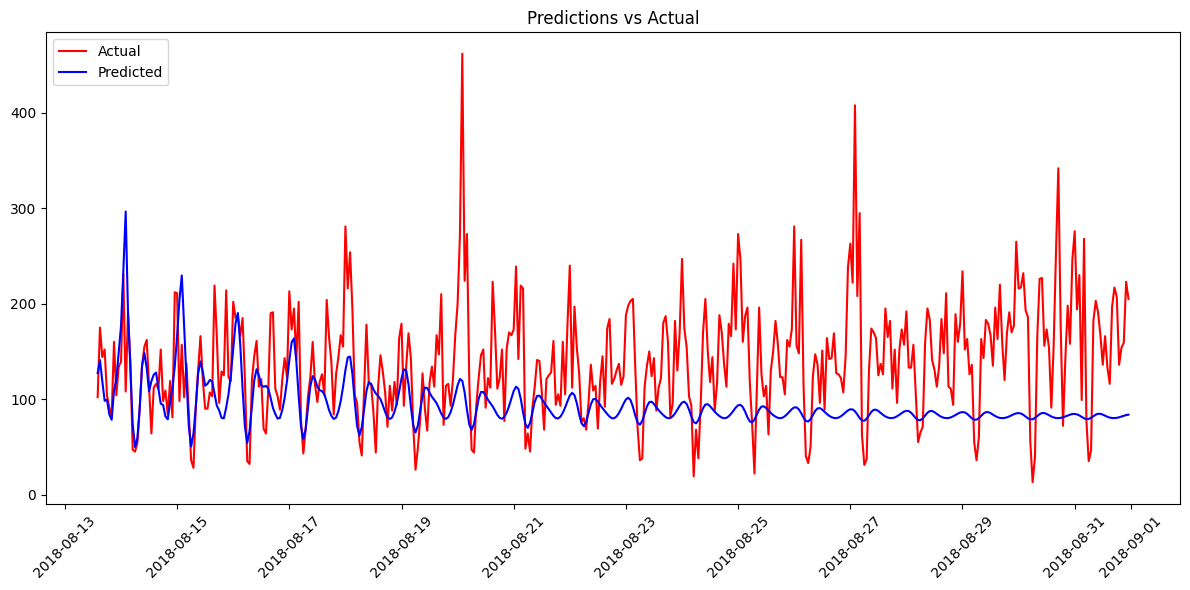

In [19]:
# Select optimal AR lags
mod = ar_select_order(train, maxlag=30, old_names=False)
ar_order = mod.ar_lags
print("Selected AR lags:", ar_order)

# aplly it in the model
test_arima(ar_order)

Test RMSE: 48.05


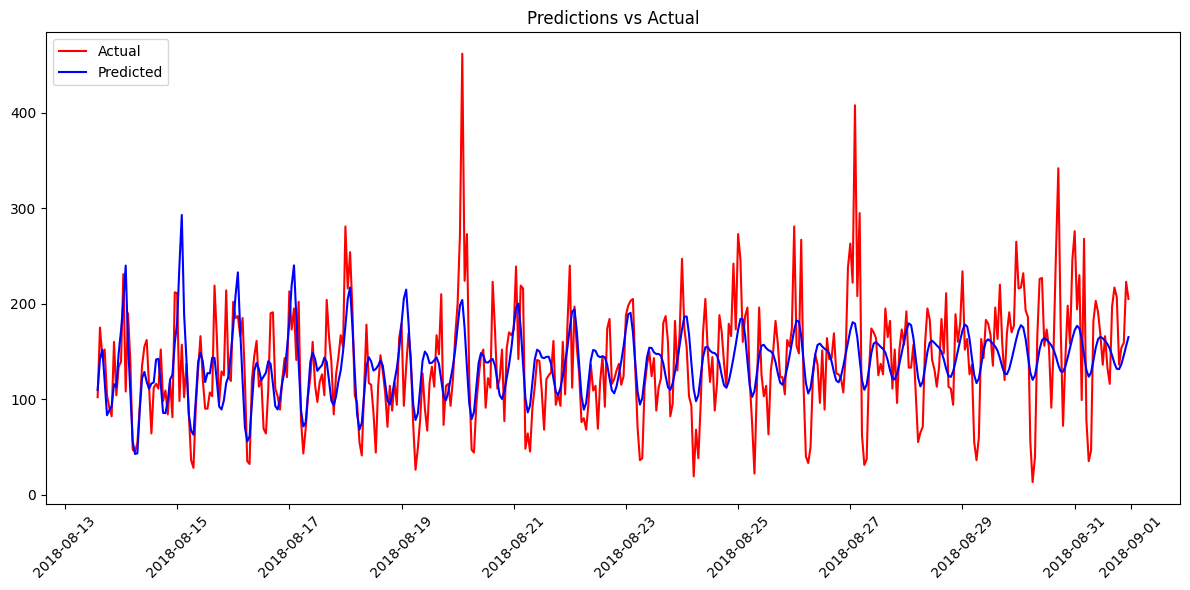

In [20]:
# Select optimal AR lags manually
test_arima([1,2,5,6,7,11,12,21,22,23,24, 26,27,46,47,48])

The lags I chose by hand worked better than the ones picked by the `ar_select_order` function. But since the RMSE is still higher than 48, we’ll need to try other models to improve the results.

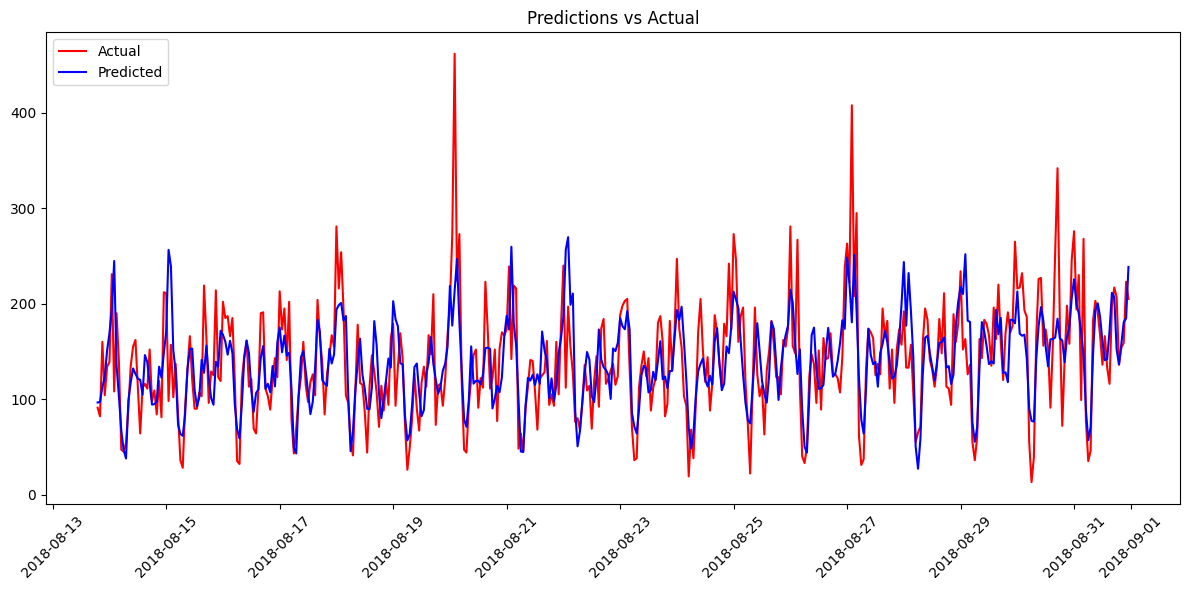

Linear Regression: RMSE = 42.67
------------------------------------------------------------------------------------------------------------------------------------------------------


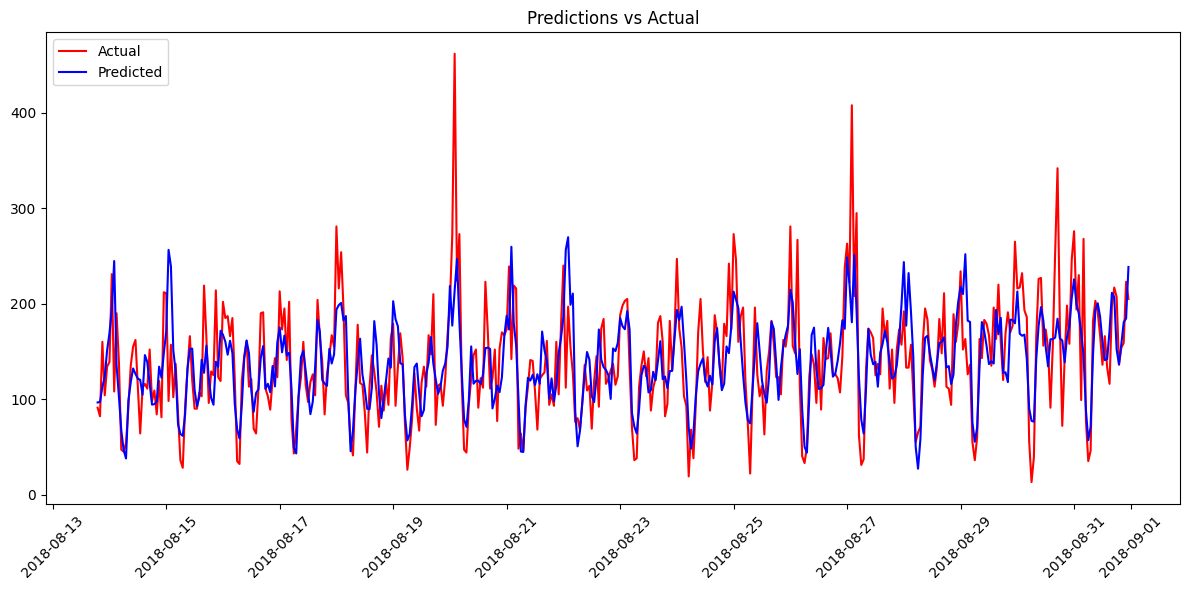

Ridge Regression: RMSE = 42.67
------------------------------------------------------------------------------------------------------------------------------------------------------


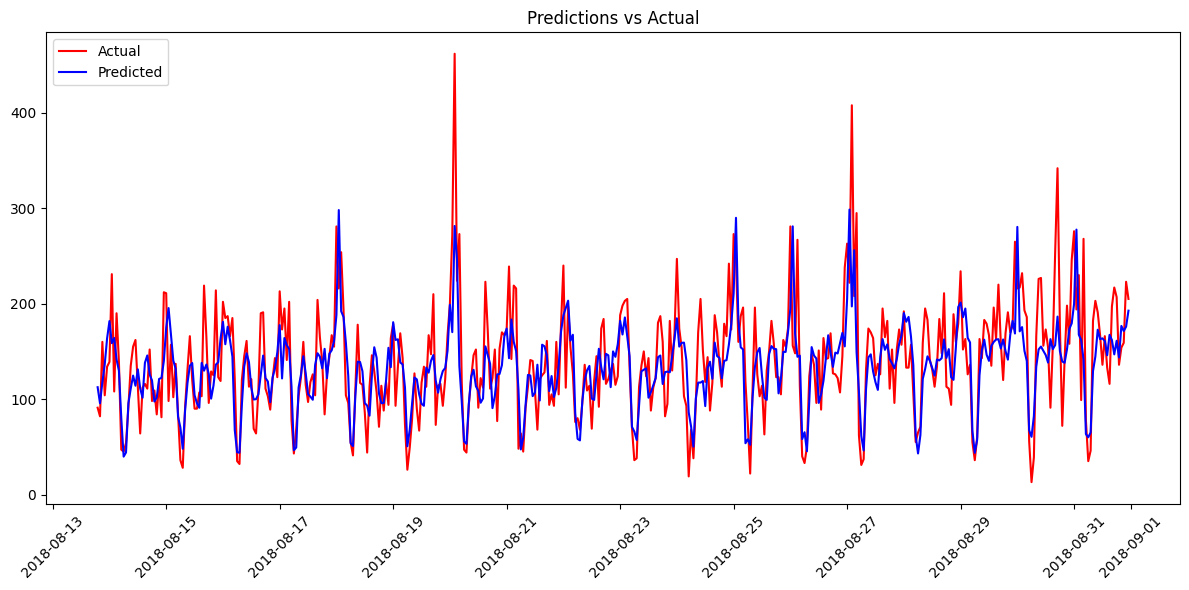

Random Forest: RMSE = 41.30
------------------------------------------------------------------------------------------------------------------------------------------------------


In [21]:
results = {}
for name, model in models.items():
    rmse = evaluate_model(model, X_train_scaled, X_test_scaled, y_train, y_test)
    results[name] = rmse
    print(f"{name}: RMSE = {rmse:.2f}")
    print('-' * 150)

Random Forest is the best model between the three models and it keeps the RMSE less than 48

LightGBM Test RMSE: 40.71


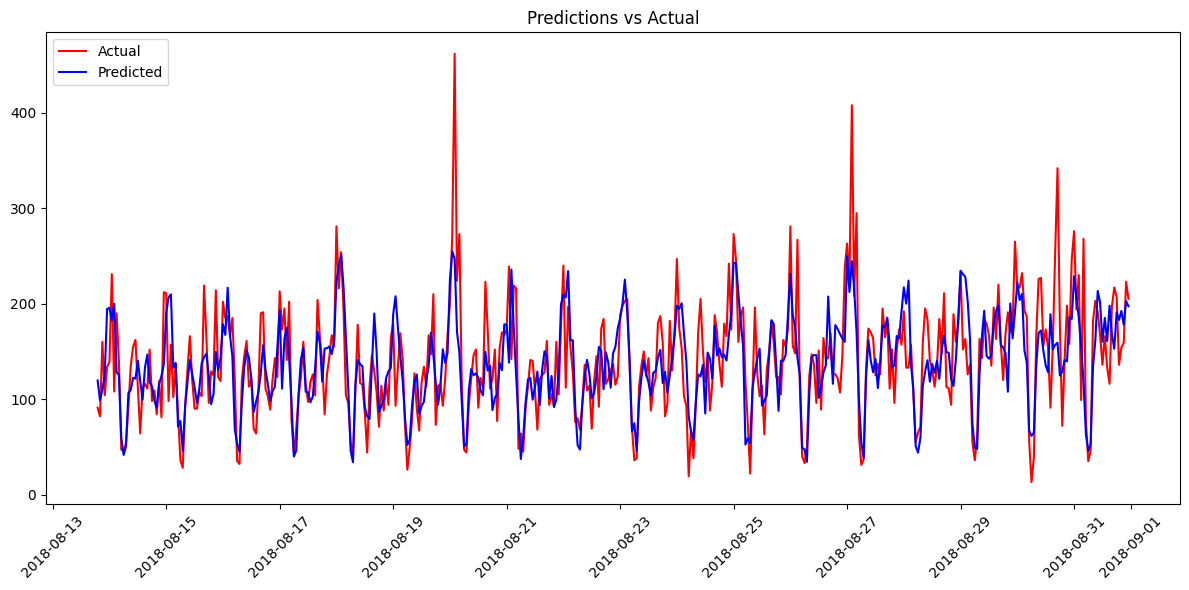

In [22]:
# Train LightGBM model
lgbm_model = LGBMRegressor(random_state=42)
lgbm_model.fit(X_train_scaled, y_train)

# Predict on test set
lgbm_pred = lgbm_model.predict(X_test_scaled)
lgbm_pred = pd.Series(lgbm_pred, index=y_test.index)

# 4. Evaluate with RMSE
rmse = np.sqrt(mean_squared_error(y_test, lgbm_pred))
print(f"LightGBM Test RMSE: {rmse:.2f}")

# Plot actual vs predicted
plot_result(y_test,lgbm_pred )


 The `LGBM Model` delivered the best results, though many of the remaining errors appear to be caused by outliers.


## Conclusion

we built different models to predict how many taxi orders would happen each hour. We cleaned the data, created helpful features like time and lag values, and tried several models to see which one worked best.

After testing AutoReg, Linear Regression, Ridge, Random Forest, and LightGBM, we found that LightGBM gave the best results. It had the lowest RMSE and was better at handling complex patterns in the data. Still, some prediction errors came from outliers—unexpected spikes that are hard for any model to guess.